------------------------------------------------------------------------------------------------------------------------

This is the results part of the project. If you want to see the source code please go to:

### Results | __[Code](https://github.com/serbanradulescu/master_thesis)__ 
------------------------------------------------------------------------------------------------------------------------

In [1]:
#this line imports the functions needed for this project
from source_code.general_functions import select_time_range
from source_code.dwd_data_explore import get_links, show_available_data, ids_datapoints, common_stations, plot_points_germany
from source_code.dwd_data_download import download_dwd_data
#from source_code.plot_functions import plot_optimal_temperature, plot_lw_RHt, plot_lw_dpd, plot_dryness # Will think how to include
from source_code.fusarium import plot_risk_fusarium, equation_fusarium, equation_fusarium_rh, plot_combined_risk_fusarium
from source_code.lm_fusarium import linear_model_temperature, linear_model_moisture
from source_code.bbch_functions import plot_harvest_date_mais, quantile_date_stage_crop


import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'


# Exploring the effects of changing agroclimatological conditions on potential occurence of major winter wheat diseases: A spatio-temporal analysis for Germany from 1960 to today



## Introduction

Disease are a major factor of yield loss. FAO estimates that around 40% of yield is lost because of pests, a big part of it being produce by diseases. They affect the plants in different ways, decreasing the yield directly or producing toxins that render the products improper for human and animal use.

![Disease triangle]("https://www.researchgate.net/profile/John-Hanna-3/publication/215471503/figure/fig1/AS:339789954994178@1458023646399/The-plant-disease-triangle-Plant-disease-occurs-when-a-virulent-pathogen-comes-into.png")

As the environment is a major factor in spreading, infection and disease development, changes in climate change affect not only the physiology of plants but also the interactions between plants and pathogens. This research aims to study the effect of climate change on different parameters affecting plant diseases in Germany, using public data from Deutscher Wetterdiends (DWD).

## Materials and methods

Data is extracted from the DWD website trough the publicly available API. Individual parameters will be studied, as well as parameters derived trough modelling those parameters (e.g. leaf wetness). In the end, prediction models will be applied on the historical data (1950 - present) and changes in disease risk occurence will be studied.

## Hypothesis

1) Recent (since 1990 ) changes in climate cause more frequent favourable disease events in key phenological stages that potentially lead to infection risk than the years before (1950-1989).

2) However, those changes occur at different intensities across Germany. Higher risks in the more martime regions (higher rainfall &  higher temperature)

## Step 1. Exploring the data

From the __[DWD website](https://opendata.dwd.de/climate_environment/CDC/observations_germany/climate/hourly/)__ we can access the following data:

1. air temperature
1. cloud types
3. cloudiness
4. dew point
5. extreme wind
6. moisture
7. precipitation
8. pressure
9. soil temperature
10. solar
11. sun
12. visibility
13. weather phenomena
14. wind
15. wind synop

### From this data, the most relevant for disease models are air temperature, dew point, moisture and precipitation. The following table summarizes the hourly data points we have for each parameter and each period.

In [2]:
parameters =("air_temperature","dew_point", "moisture", "precipitation")
dwd_links = get_links(parameters) 
show_available_data(dwd_links,"hourly",parameters = parameters)

,air_temperature,dew_point,moisture,precipitation
1950's - present,29,48,48,0
1960's - present,67,57,57,0
1970's - present,75,59,59,0
1980's - present,97,118,118,0
1990's - present,129,149,149,0
2000's - present,155,185,185,144
2010's - present,481,481,481,927


#### However, for some models we need two or more parameters to be present at the same station. Here we test what stations have data for all the 3 parameters that we counted in the previous step, from 1950 to present.

In [3]:
moisture_1950_h = ids_datapoints(dwd_links,"hourly","moisture",1950,2020)
dew_point_1950_h = ids_datapoints(dwd_links,"hourly","dew_point",1950,2020)
air_temp_1950_h = ids_datapoints(dwd_links,"hourly","air_temperature",1950,2020)

common_ids = (common_stations(common_stations(moisture_1950_h,dew_point_1950_h),air_temp_1950_h))
print("Number of stations where dew point, air temperature and moisture are measured from 1950 to present: ", len(common_ids))
print("These ID's are:", common_ids)

Number of stations where dew point, air temperature and moisture are measured from 1950 to present:  24
These ID's are: ['02014', '02601', '00691', '00867', '03032', '02261', '04104', '05705', '01639', '05371', '03631', '00701', '05100', '00656', '05906', '03730', '02597', '01975', '01691', '01550', '04887', '02290', '05792', '04371']


Upon data check, I noticed that id "02290" has the moisture only for one year, even though in the name it says that it is available for all the timeframe. It will be removed from the analysis.

### Let's plot the stations to make sure that the points are representative for whole Germany:

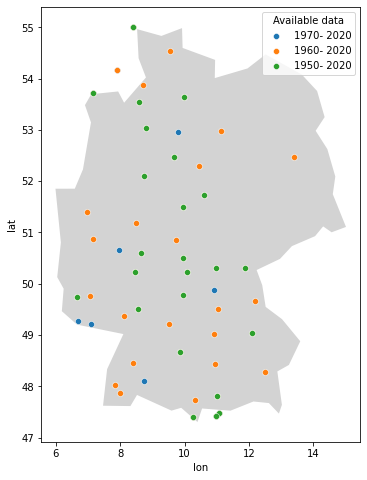

In [4]:
plot_points_germany(dwd_links)

In [5]:
try:
    common_ids.remove("02290")
except:
    print("ID was already removed")
try:
    common_ids.remove("03032") # island
except:
    print("ID was already removed")
try:
    common_ids.remove("03730") # 800m
except:
    print("ID was already removed")
try:
    common_ids.remove("01550") # 700m
except:
    print("ID was already removed")
try:
    common_ids.remove("05792") # 2900m
except:
    print("ID was already removed")


In [6]:
#to_exp = coordinates_stations(common_ids,"downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt")
#to_exp.id = to_exp.id.apply(lambda x: str(x).zfill(5))
#to_exp.to_csv("app/coordinates.csv")

#### Q: Is this map representative for Germany ?
#### No, but starting from 1970 will not change much, as the recording for weather started in GDR in the 80's.

Some thoughts:

For the Eastern part of Germany, 30 years of climate change have to be dropped from the study.

### Approximating BBCH for analysis




Q1 quantile of arr :  260.0
Q2 quantile of arr :  269.0
Q3 quantile of arr :  280.0
90% of corn is harvested at :  289.0
95% of corn is harvested at :  295.0
99% of corn is harvested at :  304.0


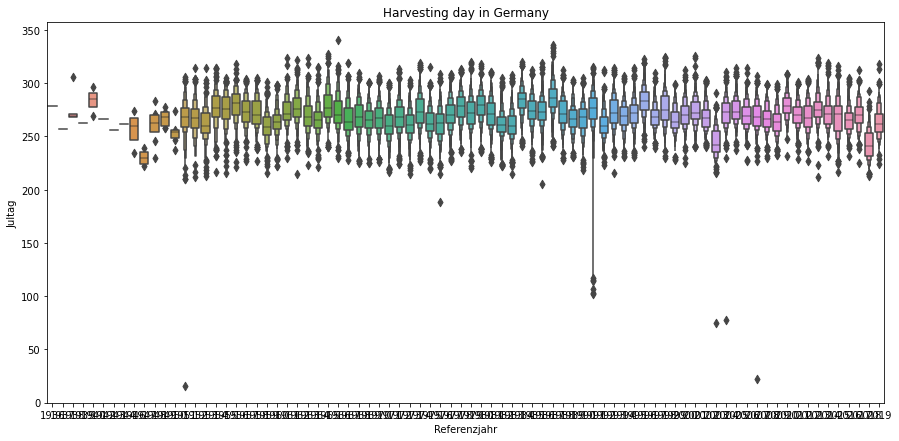

In [7]:
plot_harvest_date_mais()

In [8]:
corn_harvest_date = quantile_date_stage_crop("mais",0.90,24)
wheat_bbch75 = quantile_date_stage_crop("wheat",0.90,19)

wheat_sawing_date = quantile_date_stage_crop("wheat",0.90,10)
wheat_harvest_date = quantile_date_stage_crop("wheat",0.90,23)
print(f"""Summary 90% procent:

For fusarium:
-----------------------
Corn - harvest {corn_harvest_date}
Wheat - bbch75 {wheat_bbch75}

General for wheat:
------------------------
 Sawing date: {wheat_sawing_date}
 Harvest: {wheat_harvest_date}
 """)

Summary 90% procent:

For fusarium:
-----------------------
Corn - harvest 16.10
Wheat - bbch75 20.07

General for wheat:
------------------------
 Sawing date: 27.10
 Harvest: 26.08
 


## Step 2. Obtaining the data and ensuring quality
### 1. Temperature

In [9]:
df_airtemp = download_dwd_data("air_temperature","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)
#Replacing non-existent values
df_airtemp.replace(-999.0, np.nan, inplace=True)

All given ids accounted for


(0.0, 300000.0)

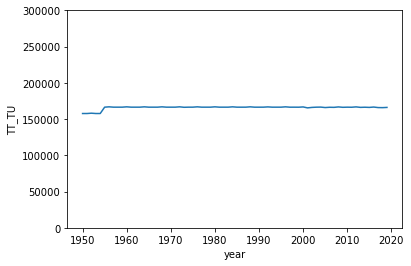

In [10]:
#Step 1. Checking data integrity:

df = df_airtemp.copy()
measures = df.groupby("year").count()
fig = plt.figure()
ax = sns.lineplot(x=measures.index,y=measures.TT_TU)
ax.set_ylim(bottom = 0, top = 300000)


Temperature has increased during the last 30 years. However, how does this reflect in plant disease optimal temperature development ?

### 2. Air humidity (RH)

In [11]:
df_moisture= download_dwd_data("moisture","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)

#Replacing non-existent values
df_moisture.replace(-99.9, np.nan, inplace=True)

All given ids accounted for


Text(0, 0.5, 'Number of measures')

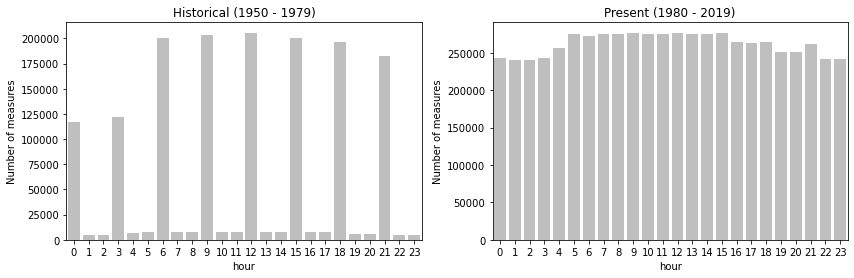

In [12]:
hist_moisture = df_moisture[df_moisture["year"]<1980].groupby("hour").count()
recent_moisture = df_moisture[df_moisture["year"]>=1980].groupby("hour").count()

fig, ax =plt.subplots(1,2,figsize=(14,4))
sns.barplot(x= hist_moisture.index, y = hist_moisture["RF_STD"], color = "0.75", ax= ax[0])
sns.barplot(x= recent_moisture.index, y = recent_moisture["RF_STD"], color = "0.75", ax= ax[1])
ax[0].set_title("Historical (1950 - 1979)")
ax[1].set_title("Present (1980 - 2019)")
ax[0].set_ylabel("Number of measures")
ax[1].set_ylabel("Number of measures")

We can observe from here that in this time period, the relative humidity was mostly measured from 3 to 3 hours, during the working time, as the measuring process was mostly manual.
From 1980, the data is measured more constantly. A solution is to limit the analysis on the hours that are measured.

In [13]:
df_moisture = df_moisture[df_moisture["hour"].isin([6, 9, 12, 15, 18, 21])]

## Step 2. Obtaining the data and ensuring quality
## Fusarium graminearum - air temperature and moisture

In [14]:
"""plot_risk_fusarium(df_airtemp, df_moisture,
temp_min=15,temp_max=25,
hist_start=1950,hist_end=1979,
#start_dd_mm="01.09", end_dd_mm="01.05",
start_dd_mm=corn_harvest_date, end_dd_mm=wheat_harvest_date, 
moving_average=7 
)"""

'plot_risk_fusarium(df_airtemp, df_moisture,\ntemp_min=15,temp_max=25,\nhist_start=1950,hist_end=1979,\n#start_dd_mm="01.09", end_dd_mm="01.05",\nstart_dd_mm=corn_harvest_date, end_dd_mm=wheat_harvest_date, \nmoving_average=7 \n)'

### Combined risk

In [15]:
#plot_combined_risk_fusarium(df_airtemp,df_moisture, moving_average = 7,hist_end = 1985,hist_start = 1950,start_dd_mm=corn_harvest_date, end_dd_mm=wheat_bbch75 , transf = None)

### Now with sqrt

In [16]:
#plot_combined_risk_fusarium(df_airtemp,df_moisture, moving_average = 7,hist_end = 1985,hist_start = 1950,start_dd_mm=corn_harvest_date, end_dd_mm=wheat_bbch75, transf = "sqrt")

In [17]:
#plot_combined_risk_fusarium(df_airtemp,df_moisture, moving_average = 7,hist_end = 1985,hist_start = 1950,start_dd_mm=corn_harvest_date, end_dd_mm=wheat_bbch75, transf = "LTRH80")

In [18]:
#plot_combined_risk_fusarium(df_airtemp,df_moisture, moving_average = 7,hist_end = 1985,hist_start = 1950,start_dd_mm=corn_harvest_date, end_dd_mm=wheat_bbch75, transf = "LTRH90")

# Making a linear regression

In [19]:
from typing import Optional
from source_code.lm_fusarium import linear_model_combined
import geopandas as gpd
from source_code.dwd_data_explore import coordinates_stations

def lm_models_germany(df_lm_summary, transf):
    """plots the points for"""
    # Preparing the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries[countries["name"] == "Germany"].plot(color="lightgrey", ax=ax)
    # Plotting for each time range


    common_ids = [id for id in df_lm_summary["id"].values]
    
    stations_coordinates = coordinates_stations(
        common_ids,
        "downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt",
    )
    
    stations_coordinates = pd.merge(stations_coordinates,df_lm_summary[["id","category"]], how = "left", on="id")
    stations_coordinates.sort_values(by="category", inplace=True)
    sns.scatterplot(
        x="lon", y="lat", hue = "category", 
        palette = {"1A":"#ff3300",'1B':"#ff5c33","1C":"#ff5c99",'2A':"#003d99", '2B':"#0066ff" ,'2C':"#80b3ff" ,'3A':"#009900", '3B':"#80ff80","3C":"#80ff00", 'AN':"#000066", },  
        data=stations_coordinates, s = 100,
    )  
    plt.legend(title="lm results")
    plt.title(f"{transf}")
    plt.show()

def linear_models_analysis(transf: Optional[str]=None):
    
    # Call the models
    lm_fusarium_t = linear_model_temperature(df_airtemp,start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75, func=equation_fusarium,year_minus=0)
    lm_fusarium_rh = linear_model_moisture(df_moisture,start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75, func=equation_fusarium_rh,year_minus=0)
    lm_fusarium_combined = lm_fusarium_combined = linear_model_combined(df_airtemp, df_moisture,start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75,func1 = equation_fusarium, func2= equation_fusarium_rh, year_minus=0, transf = transf)

    #Save them for interpretation
    if transf == None:
        prefix = "v1"
    else:
        prefix = transf
    lm_fusarium_t.to_csv("results/lm_fusarium_t.csv", float_format='%.5f')
    lm_fusarium_rh.to_csv("results/lm_fusarium_rh.csv",float_format='%.5f')
    lm_fusarium_combined.to_csv(f"results/lm_fusarium_combined_{prefix}.csv", float_format='%.5f')

    # Create the merged interpretation for ppt
    lm_fusarium_t_ppt = lm_fusarium_t[["station id","conclusion"]].rename(columns={"conclusion":"temperature"})
    lm_fusarium_rh_ppt = lm_fusarium_rh[["station id","conclusion"]].rename(columns={"conclusion":"humidity"})
    lm_fusarium_combined_ppt = lm_fusarium_combined[["station id","conclusion"]].rename(columns={"conclusion":"temperature and humidity"})
    lm_fusarium_ppt = lm_fusarium_combined_ppt.merge(lm_fusarium_rh_ppt, on="station id").merge(lm_fusarium_t_ppt, on="station id")
    lm_fusarium_ppt = lm_fusarium_ppt.replace({"significant":"+", "significant but decreasing risk":"-", "non-significant":"0"})
    lm_fusarium_ppt["category"] = lm_fusarium_ppt.apply(lambda x:  str(x["temperature and humidity"])+str(x["temperature"])+str(x["humidity"]), axis=1)
    print(lm_fusarium_ppt["category"].unique())
    dict_replace = { "+++": "1A", # all risks increased
                "++0": "1B",  # combined and temperature increased
                "++-": "1C", # combined, temperature increased, humidity did not
                "0++": "2A", # temperature and humidity increased, but combined not significant
                "0+0": "2B", # temperature risk increased, humidity constant, combined not significant
                "0+-": "2C", # temperature risk increased, humidity decreased, combined not significant
                "-+0": "3A", # decreasing but temperature increased
                "-+-": "3B", # temperature increasing, humidity and combined decreasing
                "-++": "3C", # risk decreasing, both parameters increasing 
                "000": "AN", # anomaly, sky station
    }
    lm_fusarium_ppt["category"].replace(to_replace=dict_replace,inplace=True)
    print(lm_fusarium_ppt["category"].unique())
    lm_fusarium_ppt.to_csv("results/lm_fusarium_ppt.csv")

    # Prepare for plot


    summary_series =lm_fusarium_ppt['category'].value_counts().reset_index().sort_values(by="index").rename(columns={"category":"count", "index":"category"})
    lm_category_summary = pd.DataFrame(data={"category": ["1A","1B","1C","2A","2B","2C","3A","3B","3C","AN"], 
    "details":["all risks increased", "combined and temperature increased","combined, temperature increased, humidity did not","temperature and humidity increased, but combined not significant",
    "temperature risk increased, humidity risk constant, combined not significant", "temperature risk increased, humidity decreased, combined not significant",
    "decreasing but temperature increased","temperature risk increasing, humidity risk constant and combined decreasing","+--", "anomaly" ]  })
    lm_category_summary = pd.merge(summary_series,lm_category_summary, how = "left", on="category")
    print(lm_category_summary)
    lm_category_summary.to_csv("results/category_summary.csv")
    lm_fusarium_ppt.rename(columns={"station id": "id"}, inplace=True)
    lm_models_germany(df_lm_summary=lm_fusarium_ppt, transf=prefix)




### Linear model v1.

In [20]:
#linear_models_analysis(transf=None)

### Linear model sqrt(v1)

In [21]:
#linear_models_analysis(transf="sqrt")

### Linear model LTRH80

In [22]:
#linear_models_analysis(transf="LTRH80")

In [23]:
### Linear model LTRH90

['0++' '0+0' '++0' '+++' '++-' '0+-']
['2A' '2B' '1B' '1A' '1C' '2C']
  category  count                                            details
0       1A      4                                all risks increased
1       1B      6                 combined and temperature increased
2       1C      4  combined, temperature increased, humidity did not
3       2A      2  temperature and humidity increased, but combin...
4       2B      2  temperature risk increased, humidity risk cons...
5       2C      1  temperature risk increased, humidity decreased...


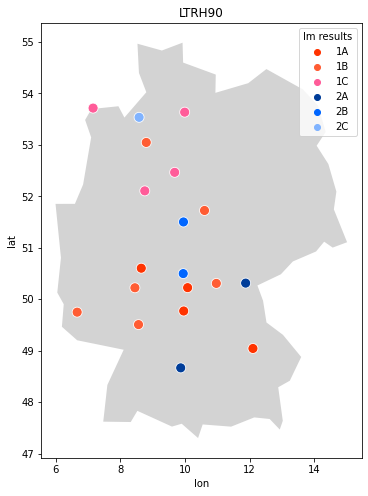

In [24]:
linear_models_analysis(transf="LTRH90")

### Preparing for .ppt

In [25]:
# Step 2.1: merge the dataframes on the needed parameters
common_cols = ["MESS_DATUM", "STATIONS_ID", "year", "month", "day", "hour"]
df_merged = df_airtemp.merge(
        df_moisture,
        how="left",
        on=["MESS_DATUM", "STATIONS_ID", "year", "month", "day", "hour"],
    )
df_merged = df_merged[common_cols + ["TT_TU", "RF_STD"]]

### Now piece-wise linear regressions

In [26]:
import piecewise_regression
import matplotlib.pyplot as plt


def piecewise_fusarium(df_param:pd.DataFrame, transf:Optional[str],start_dd_mm: str,end_dd_mm: str, to_plot: bool = False):
    df_param = select_time_range(
        df_param, start_dd_mm=start_dd_mm, end_dd_mm=end_dd_mm
    )
    piecewise_dict = {}
    for station in df_param.STATIONS_ID.unique():
        df = df_param.copy()
        start_dd_mm = corn_harvest_date
        end_dd_mm = wheat_bbch75
        df = df[df["STATIONS_ID"] == station]
        df = select_time_range(df, start_dd_mm=start_dd_mm, end_dd_mm=end_dd_mm)
        
        if transf == "airtemp":
            df["concerned_parameter"] = df.TT_TU.apply(equation_fusarium)
        elif transf == "moisture":
            df["concerned_parameter"] = df.RF_STD.apply(equation_fusarium_rh)
        else:
            df["t_risk"] = df.TT_TU.apply(equation_fusarium)
            df["rh_risk"] = df.RF_STD.apply(equation_fusarium_rh)
            if transf == "v1":
                df["concerned_parameter"] = df.apply(lambda x: (x["rh_risk"] * x["t_risk"]), axis=1)
            elif transf == "sqrt":
                df["concerned_parameter"] = df.apply(
                    lambda x: np.sqrt(x["rh_risk"] * x["t_risk"]), axis=1)
            elif transf == "LTRH80":
                df["concerned_parameter"] = df.apply(lambda x: x["t_risk"] if x["RF_STD"] > 80 else 0, axis=1)
            elif transf == "LTRH90":
                df["concerned_parameter"] = df.apply(lambda x: x["t_risk"] if x["RF_STD"] > 90 else 0, axis=1)

        df = df.groupby(["year"]).mean().reset_index()
        x = [i for i in df.year]
        y = [i for i in df.concerned_parameter]
        try:
            pw_fit = piecewise_regression.Fit(x, y, n_breakpoints=1)
            pw_results = pw_fit.get_results()
            piecewise_dict[station] = pw_results["estimates"]["breakpoint1"]["estimate"]
            print(station, pw_results["estimates"]["breakpoint1"]["estimate"])
        except: 
            piecewise_dict[station] = 0
            print(station, "No breaking point")
        if to_plot == True and piecewise_dict[station] != 0:
            fig = plt.figure()
            # Plot the data, fit, breakpoints and confidence intervals
            pw_fit.plot_data(color="grey", s=20)
            # Pass in standard matplotlib keywords to control any of the plots
            pw_fit.plot_fit(color="red", linewidth=2)
            pw_fit.plot_breakpoints()
            pw_fit.plot_breakpoint_confidence_intervals()
            plt.title(f"Station:{station}, model: fusarium {transf}")
            plt.xlabel("x")
            plt.ylabel("y")
            #plt.show()
            fig.savefig(f'results/plots/piecewise/{transf}/{station}.png')
            plt.close()
    piecewise_df = pd.DataFrame.from_dict(piecewise_dict, orient="index").reset_index().rename(columns={"index":"id", 0:"breakpoint"})
    return piecewise_df

#piecewise_df_temp = piecewise_fusarium(df_param = df_airtemp, transf= "airtemp",start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75, to_plot= True)
#1piecewise_df_moisture = piecewise_fusarium(df_param = df_moisture, transf= "moisture", to_plot= False)
#pieceweise_df_LTRH90 = piecewise_fusarium(df_param = df_merged, transf= "LTRH90",start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75, to_plot= True)


In [27]:
plot_piecewise = pieceweise_df_LTRH90[pieceweise_df_LTRH90["breakpoint"] != 0]
piecewise_ids = pieceweise_df_LTRH90["id"].values
#piecewise_ids_v2 = ['04104', '03631', '03730', '02597', '05705', '00701', '02261', '05100', '01639', '01550', '02014', '01691', '05906', '05792', '04371', '05371', '00656', '04887', '03032', '01975', '02601', '00691']
#piecewise_ids_v1 = ["05705","03631","01639","05100","03032","01691", "00691","02597", "01975","04887","04371","00656","01550"]
#plot_piecewise = plot_piecewise[plot_piecewise["id"].isin(piecewise_ids)]
#plot_piecewise = plot_piecewise[plot_piecewise["breakpoint"]<2010]
#plot_piecewise = plot_piecewise[plot_piecewise["breakpoint"]>1960]
print(plot_piecewise)

ax = sns.scatterplot(x = plot_piecewise["breakpoint"], y = 1)


NameError: name 'pieceweise_df_LTRH90' is not defined

In [ ]:
#piecewise_ids =pieceweise_df_LTRH90[pieceweise_df_LTRH90["breakpoint"] != 0]["id"].values
#piecewise_ids = [i for i in piecewise_ids]
#print(piecewise_ids)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

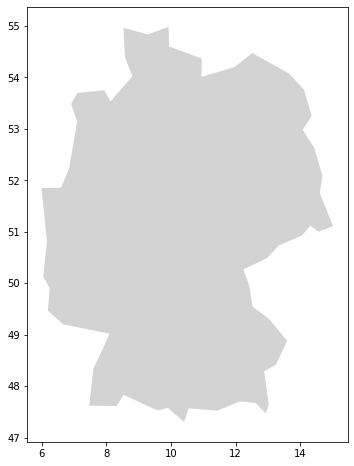

In [ ]:
# Let's plot the 13 I would say are clearly better explained by a piecewise regression:
def plot_germany_piecewise_models(plot_piecewise:pd.DataFrame, piecewise_ids:list):
    # Preparing the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries[countries["name"] == "Germany"].plot(color="lightgrey", ax=ax)

    # Plotting for each time range
    common_ids = piecewise_ids

    stations_coordinates = coordinates_stations(
        common_ids,
        "downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt",
    )

    # Merging it with the two
    stations_coordinates = pd.merge(stations_coordinates,plot_piecewise[["id","breakpoint"]], how = "left", on="id")
    stations_coordinates.dropna(inplace = True)


    

    
   
    stations_coordinates.sort_values(by="breakpoint", inplace=True)
    print(stations_coordinates)
    sns.scatterplot(
        x="lon", y="lat", hue = "breakpoint", 
        data=stations_coordinates, s = 100,
    )  
    for x,y,z in zip(stations_coordinates["lon"],stations_coordinates["lat"],[round(i) for i in stations_coordinates["breakpoint"]]):
        ax.text(x-0.75,y+0.01,f'{z: .0f}',horizontalalignment='center',color='black',weight='light')
    plt.title(f"With piecewise")
    plt.show()
    """
    """

#plot_germany_piecewise_models(plot_piecewise, piecewise_ids)

      id      lat      lon   breakpoint
0  00701  53.5332   8.5761  1955.964074
3  04887  48.6656   9.8648  1961.705353
1  01691  51.5002   9.9507  1984.316434
2  02261  50.3123  11.8760  2007.059673
4  05371  50.4973   9.9427  2013.391975


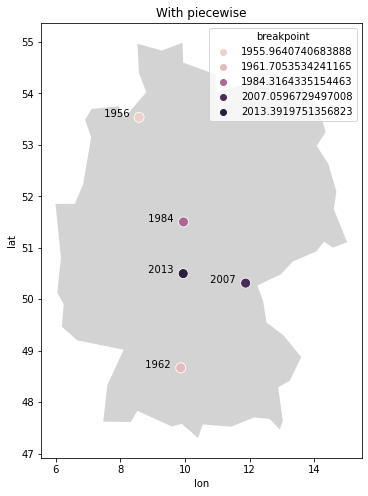

In [ ]:
#plot_germany_piecewise_models(plot_piecewise, piecewise_ids = ["00701","01691","05371","02261","04887"])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


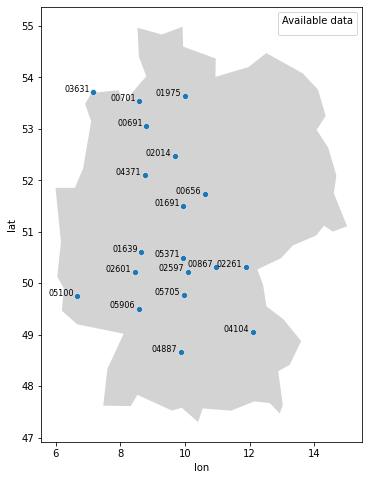

In [221]:
import matplotlib.pyplot as plt
def plot_selected_points_germany(common_ids):
    """plots the points for"""
    # Preparing the plot
    fig, ax = plt.subplots(figsize=(12, 8))
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries[countries["name"] == "Germany"].plot(color="lightgrey", ax=ax)
    # Plotting for each time range

    stations_coordinates = coordinates_stations(
            common_ids,
            "downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt",
        )

    sns.scatterplot(
            x="lon", y="lat", data=stations_coordinates, 
        )  # ,title=f"Weather stations that measure the parameters required for applying \n the disease models in the time period of {start_year} - present",  ax=ax)
    #print(stations_coordinates.columns)
    plt.legend(title="Available data")
    for x,y,z in zip(stations_coordinates["lon"],stations_coordinates["lat"],[i for i in stations_coordinates["id"]]):
        ax.text(x-0.5,y+0.01,f'{z}',horizontalalignment='center',color='black',weight='light', fontsize = 8)
    plt.show()
plot_selected_points_germany(common_ids)

### Predictions

In [62]:
df_merged_test = df_merged[df_merged["STATIONS_ID"]=="04887"]
df_merged_test = df_merged[df_merged["year"] >= 2010]
#print(df_merged_test.year.unique)

<bound method Series.unique of 525945      2010
525946      2010
525947      2010
525948      2010
525949      2010
            ... 
11610158    2019
11610159    2019
11610160    2019
11610161    2019
11610162    2019
Name: year, Length: 1664220, dtype: int64>


['04887' '05371' '05100' '02597' '02261' '01975' '00691' '04104' '01639'
 '00867' '00701' '05705' '05906' '02601' '03631' '04371' '01691' '00656'
 '02014']
[10, 20, 30]


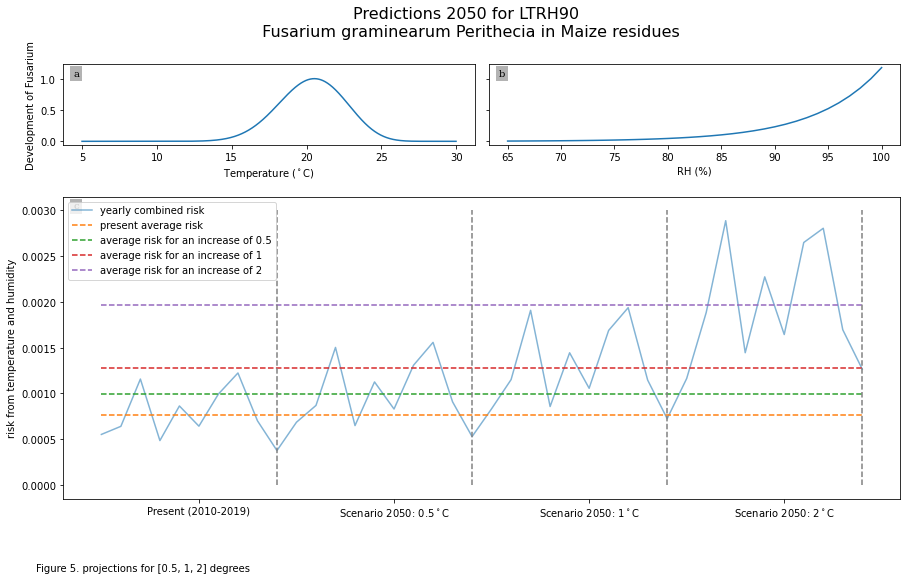

In [93]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.transforms as mtransforms

def plot_prediction_model(df_param:pd.DataFrame, start_dd_mm: str,end_dd_mm: str,moving_average: int = 7,transf:Optional[str] = None, 
    hist_start: int = 2010, hist_end: int = 2019,  degrees: list[float] = [0.5, 1, 2]):

    df_param = df_param[df_param["year"]>= hist_start]
    df_param = select_time_range(df_param, start_dd_mm=start_dd_mm, end_dd_mm=end_dd_mm)
    df_merged = df_param.copy()


    plot_helper_list = [i for i in range(10, (len(degrees)+1)*10 , 10)]
    print(plot_helper_list)
    for i, j in zip(plot_helper_list , degrees):
        # Step 2.1: add the degrees for prediction:
        df_2050 = df_param.copy()
        df_2050["year"] = df_2050["year"].apply(lambda x:x +i)
        df_2050["TT_TU"] = df_2050["TT_TU"].apply(lambda x: x +j)

        # Step 2.2: merge the two dataframes
        df_merged = pd.concat([df_merged,df_2050],ignore_index=True, axis =0)
    
    # print(df_merged["year"].unique)
    # Step 2.2: the model for temperature
    df_merged["t_risk"] = df_merged.TT_TU.apply(equation_fusarium)


    

    # Step 2.4: overall risk (combined)
    if transf == None:
        df_merged["rh_risk"] = df_merged.RF_STD.apply(equation_fusarium_rh)
        df_merged["combined_risk"] = df_merged.apply(
            lambda x: (x["rh_risk"] * x["t_risk"]), axis=1
        )
    elif transf == "sqrt":
        df_merged["rh_risk"] = df_merged.RF_STD.apply(equation_fusarium_rh)
        df_merged["combined_risk"] = df_merged.apply(
            lambda x: np.sqrt(x["rh_risk"] * x["t_risk"]), axis=1
        )
    elif transf == "LTRH80":
        df_merged["combined_risk"] = df_merged.apply(
            lambda x: x["t_risk"] if x["RF_STD"] > 80 else 0, axis=1
        )
    elif transf == "LTRH90":
        df_merged["combined_risk"] = df_merged.apply(
            lambda x: x["t_risk"] if x["RF_STD"] > 90 else 0, axis=1
        )

    # Step 3: apply the function for the model
    df_results = df_merged.groupby(["year"]).mean()
    avg_hist = df_results[
        (df_results.index <= hist_end) & (df_results.index >= hist_start)  # type: ignore
    ]["combined_risk"].mean()
    max_hist = df_results[
        (df_results.index <= hist_end) & (df_results.index >= hist_start)  # type: ignore
    ]["combined_risk"].max()
    min_hist = df_results[
        (df_results.index <= hist_end) & (df_results.index >= hist_start)  # type: ignore
    ]["combined_risk"].min()
    df_results[f"{moving_average}years_average"] = df_results.combined_risk.rolling(
        moving_average
    ).mean()

    # Close the gap

    # Step 4: plot
    # Step 4.1: Make a grid
    gs = gridspec.GridSpec(10, 10)
    fig = plt.figure(figsize=(15, 8))

    # Step 4.2: Plot in different spaces of the grid
    # Step 4.2.1: Left upper corner
    ax1 = fig.add_subplot(gs[0:2, 0:5])
    degr = [equation_fusarium(i / 100) for i in range(500, 3000, 1)]
    sns.lineplot(x=[i / 100 for i in range(500, 3000, 1)], y=degr, ax=ax1)
    ax1.set_xlabel("Temperature ($^\circ$C)")
    ax1.set_ylabel("Development of Fusarium")

    # Step 4.2.2: Right upper corner
    ax2 = fig.add_subplot(gs[0:2, 5:10], sharey=ax1)
    degr = [equation_fusarium_rh(i) for i in range(65, 101)]
    sns.lineplot(x=[i for i in range(65, 101)], y=degr, ax=ax2)
    ax2.set_xlabel("RH (%)")
    plt.setp(ax2.get_yticklabels(), visible=False)

    # Step 4.2.3: Middle center
    ax3 = fig.add_subplot(gs[3:11, :])
    sns.lineplot(
        x="year",
        y="combined_risk",
        data=df_results,
        label="yearly combined risk",
        ax=ax3,
        alpha=0.55,
    )
    """
    sns.lineplot(
        x="year",
        y=f"{moving_average}years_average",
        ax=ax3,
        data=df_results,
        label=f"{moving_average} years average",
    )
    # sns.lineplot(x = df_airtemp.index, y = min_hist,linestyle="dashed",ax=ax3, label=f"minimum in the historical period ({hist_start}-{hist_end})")
    """
    sns.lineplot(
            x=df_results.index,
            y=avg_hist,
            linestyle="dashed",
            ax=ax3,
            label=f"present average risk",
        )

    for i, j in zip(plot_helper_list , degrees):
        period_avg = df_results[(df_results.index <= hist_end+i) & (df_results.index >= hist_start+i)]["combined_risk"].mean()
        sns.lineplot(
            x=df_results.index,
            y=period_avg ,
            linestyle="dashed",
            ax=ax3,
            label=f"average risk for an increase of {j}",
        )

    ax3.set_xlabel("")
    ax3.set_ylabel("risk from temperature and humidity")

    #for i in range(2019,2069,10):
    for i in range(2019, 2019 +(len(degrees)+1)*10 , 10):
        ax3.plot([i,i],[0,0.003],color='gray', linestyle='dashed')

    # Step 4.3: Add suptitles, labels, ticks
    fig.suptitle(
        f"Predictions 2050 for {transf} \n Fusarium graminearum Perithecia in Maize residues",
        fontsize=16,
    )
    for ax, label in zip([ax1, ax2, ax3], ["a", "b", "c"]):
        trans = mtransforms.ScaledTranslation(10 / 72, -5 / 72, fig.dpi_scale_trans)
        ax.text(
            0,
            1,
            label,
            transform=ax.transAxes + trans,
            fontsize="medium",
            verticalalignment="top",
            fontfamily="serif",
            bbox=dict(facecolor="0.7", edgecolor="none", pad=3.0),
        )

    plt.figtext(
        0.1,
        0.00,
        f"Figure 5. projections for {degrees} degrees",
    )
    postion_ticks = [i for i in range(2015, 2015+(len(degrees)+1)*10 , 10)]
    name_ticks = ["Present (2010-2019)"] + [f"Scenario 2050: {i}$^\circ$C" for i in degrees]
    plt.xticks(postion_ticks, name_ticks)

    plt.show()

plot_prediction_model(df_param=df_merged_test, transf = "LTRH90", start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75 )


In [138]:
def table_stations_predictions(df_param:pd.DataFrame, start_dd_mm: str,end_dd_mm: str,moving_average: int = 7,transf:Optional[str] = None, hist_start: int = 2010, hist_end: int = 2019,  degrees: list[float] = [0.5, 1, 2]):
    df_param = df_param[df_param["year"]>= hist_start]
    df_param = select_time_range(df_param, start_dd_mm=start_dd_mm, end_dd_mm=end_dd_mm)
    df_merged = df_param.copy()


    plot_helper_list = [i for i in range(10, (len(degrees)+1)*10 , 10)]
    print(plot_helper_list)
    for i, j in zip(plot_helper_list , degrees):
        # Step 2.1: add the degrees for prediction:
        df_2050 = df_param.copy()
        df_2050["year"] = df_2050["year"].apply(lambda x:x +i)
        df_2050["TT_TU"] = df_2050["TT_TU"].apply(lambda x: x +j)

        # Step 2.2: merge the two dataframes
        df_merged = pd.concat([df_merged,df_2050],ignore_index=True, axis =0)
    
    # print(df_merged["year"].unique)
    # Step 2.2: the model for temperature
    df_merged["t_risk"] = df_merged.TT_TU.apply(equation_fusarium)


    

    # Step 2.4: overall risk (combined)
    if transf == None:
        df_merged["rh_risk"] = df_merged.RF_STD.apply(equation_fusarium_rh)
        df_merged["combined_risk"] = df_merged.apply(
            lambda x: (x["rh_risk"] * x["t_risk"]), axis=1
        )
    elif transf == "sqrt":
        df_merged["rh_risk"] = df_merged.RF_STD.apply(equation_fusarium_rh)
        df_merged["combined_risk"] = df_merged.apply(
            lambda x: np.sqrt(x["rh_risk"] * x["t_risk"]), axis=1
        )
    elif transf == "LTRH80":
        df_merged["combined_risk"] = df_merged.apply(
            lambda x: x["t_risk"] if x["RF_STD"] > 80 else 0, axis=1
        )
    elif transf == "LTRH90":
        df_merged["combined_risk"] = df_merged.apply(
            lambda x: x["t_risk"] if x["RF_STD"] > 90 else 0, axis=1
        )

    # Step 3: apply the function for the model
    dict_results = {"station":[],"avg_present":[] ,  "Forecast 2050: 0.5":[],"Forecast 2050: 1":[], "Forecast 2050: 2":[]} #| {f"Forecast 2050: {i}":[] for i in degrees}

    for station in df_merged.STATIONS_ID.unique():
        df_results = df_merged[df_merged["STATIONS_ID"]==station]
        df_results = df_results.groupby(["year"]).mean().reset_index()
        df_results["year"] = df_results["year"].astype(int)
        avg_present = df_results[
            (df_results.year <= hist_end) & (df_results.year >= hist_start)  # type: ignore
        ]["combined_risk"].mean()
        dict_results["station"] += [station]
        dict_results["avg_present"] += [avg_present]
        dict_results["Forecast 2050: 0.5"] += [df_results[(df_results.year>=2020) & (df_results.year<2030)  ]["combined_risk"].mean()]
        dict_results["Forecast 2050: 1"] += [df_results[(df_results.year>=2030) & (df_results.year<2040)  ]["combined_risk"].mean()]
        dict_results["Forecast 2050: 2"] += [df_results[(df_results.year>=2040) & (df_results.year<2050)  ]["combined_risk"].mean()]

        #df_results = 
    return pd.DataFrame.from_dict(dict_results)

dict_results = table_stations_predictions(df_param=df_merged_test, transf = "LTRH90", start_dd_mm = corn_harvest_date,end_dd_mm = wheat_bbch75 )

[10, 20, 30]


In [216]:
df_results = dict_results.copy(deep=True)
for col in ["Forecast 2050: 0.5","Forecast 2050: 1","Forecast 2050: 2"]:
    df_results[col] = df_results.apply(lambda x:  x[col] / x["avg_present"] * 100 , axis = 1 )
    df_results = df_results.round({col: 1})
df_results.to_csv("results/predictions/prediction.csv")
print(df_results)

   station  avg_present  Forecast 2050: 0.5  Forecast 2050: 1  \
0    04887     0.000339               139.2             190.1   
1    05371     0.000168               150.2             220.6   
2    05100     0.000848               134.7             176.6   
3    02597     0.000860               131.5             168.7   
4    02261     0.000207               145.9             206.6   
5    01975     0.001066               126.6             157.5   
6    00691     0.001010               128.9             162.8   
7    04104     0.000721               131.2             169.2   
8    01639     0.000984               129.6             164.1   
9    00867     0.000691               130.7             167.1   
10   00701     0.001154               129.0             162.9   
11   05705     0.000570               131.4             168.7   
12   05906     0.001057               127.9             160.0   
13   02601     0.000270               143.8             202.5   
14   03631     0.000973  

['04887', '05371', '05100', '02597', '02261', '01975', '00691', '04104', '01639', '00867', '00701', '05705', '05906', '02601', '03631', '04371', '01691', '00656', '02014']


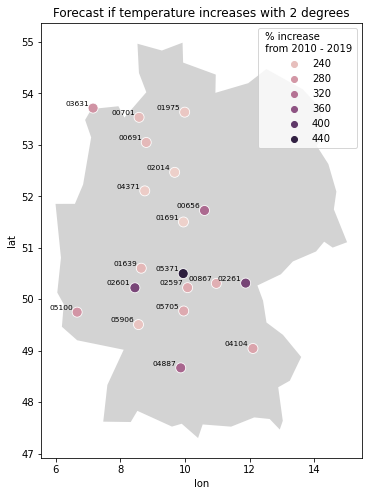

In [251]:
def plot_prediction_model_germany(df_predict:pd.DataFrame):
    df_predict = df_predict.rename(columns= {"station":"id"})
    fig, ax = plt.subplots(figsize=(12, 8))
    countries = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))
    countries[countries["name"] == "Germany"].plot(color="lightgrey", ax=ax)
    # Plotting for each time range
    
    common_ids = [i for i in df_predict.id.unique()]
    print(common_ids)
    stations_coordinates = coordinates_stations(common_ids,"downloads/hourly/dew_point/TD_Stundenwerte_Beschreibung_Stationen.txt")
    stations_coordinates = pd.merge(stations_coordinates,df_predict[["id","Forecast 2050: 2"]], how = "left", on="id")
    sns.scatterplot(x="lon", y="lat", hue="Forecast 2050: 2", data=stations_coordinates, s = 100)  # ,title=f"Weather stations that measure the parameters required for applying \n the disease models in the time period of {start_year} - present",  ax=ax)

    for x,y,z in zip(stations_coordinates["lon"],stations_coordinates["lat"],[i for i in stations_coordinates["id"]]):
        ax.text(x-0.5,y+0.05,f'{z}',horizontalalignment='center',color='black',weight='light', fontsize = 7.5)
    plt.legend(title=" % increase \n from 2010 - 2019")
    plt.title("Forecast if temperature increases with 2 degrees")
    #plt.show()
plot_prediction_model_germany(df_results)
#plot_selected_points_germany(df_results.station.unique())

## Climate change in Germany

In [215]:
import scipy.stats as stats
from statsmodels.stats.multicomp import pairwise_tukeyhsd

def study_climate_change_temperature(df_airtemp:pd.DataFrame):
    dict_results = {"decade":[],"t_average":[]}
    #for i in range(1950,2019,10):
    #this_df = df_airtemp[df_airtemp["year"].isin(range(i,i+10,1))]
    this_df = df_airtemp[["year","TT_TU"]].groupby(["year"]).mean().reset_index()
    this_df["decade"] = this_df.apply(lambda x: int(str(x["year"])[0:3]) , axis  = 1 )
    #print(this_df)
    sns.scatterplot(y=this_df["TT_TU"], x=this_df["year"])
    sns.violinplot(x=this_df["decade"], y=this_df["TT_TU"])

    #for i in range(195,202,1):
    to_stat = [this_df[this_df["decade"]==i]["TT_TU"] for i in range(195,202,1)]
    fvalue, pvalue = stats.f_oneway(*to_stat)
    #this_df[this_df["decade"]==195]["TT_TU"], this_df[this_df["decade"]==201]["TT_TU"])
    #this_df[this_df["decade"]==196], this_df[this_df["decade"]==197], this_df[this_df["decade"]==198],this_df[this_df["decade"]==199],this_df[this_df["decade"]==200],this_df[this_df["decade"]==201])
    print(fvalue,pvalue)

    tukey = pairwise_tukeyhsd(endog=this_df['TT_TU'],
                          groups=this_df['decade'],
                          alpha=0.05)

    #display results
    print(tukey)

#study_climate_change_temperature(df_airtemp)

In [214]:
def study_climate_change_rh(df_moisture:pd.DataFrame):
    dict_results = {"decade":[],"t_average":[]}
    #for i in range(1950,2019,10):
    #this_df = df_airtemp[df_airtemp["year"].isin(range(i,i+10,1))]
    #this_df = df_moisture[["year","RF_STD"]].groupby(["year"]).mean().reset_index()
    #this_df = df_moisture[["year","RF_STD"]]
    #this_df["decade"] = this_df.apply(lambda x: int(str(x["year"])[0:3]) , axis  = 1 )
    #print(this_df)
    #sns.scatterplot(y=this_df["RF_STD"], x=this_df["year"])
    #sns.violinplot(x=this_df["decade"], y=this_df["RF_STD"])

    #for i in range(195,202,1):
    #to_stat = [this_df[this_df["decade"]==i]["RF_STD"] for i in range(195,202,1)]
    #fvalue, pvalue = stats.f_oneway(*to_stat)
    #this_df[this_df["decade"]==195]["TT_TU"], this_df[this_df["decade"]==201]["TT_TU"])
    #this_df[this_df["decade"]==196], this_df[this_df["decade"]==197], this_df[this_df["decade"]==198],this_df[this_df["decade"]==199],this_df[this_df["decade"]==200],this_df[this_df["decade"]==201])
    #rint(fvalue,pvalue)

    #tukey = pairwise_tukeyhsd(endog=this_df['RF_STD'],
    #                      groups=this_df['decade'],
     #                     alpha=0.05)

    #display results
    #print(tukey)

    for month in range(1,13,1):
        #this_df = df_airtemp[["year","TT_TU"]]
        monthly_df = df_moisture[df_moisture["month"]==month][["year","RF_STD"]]
        monthly_df = monthly_df.groupby(["year"]).mean().reset_index()
        
        monthly_df["decade"] = monthly_df.apply(lambda x: int(str(x["year"])[0:3]) , axis  = 1 )
        
        to_stat = [monthly_df[monthly_df["decade"]==i]["RF_STD"] for i in range(195,202,1)]
        fvalue, pvalue = stats.f_oneway(*to_stat)
        if pvalue <= 0.05:
            print(month, pvalue)
            sns.violinplot(x=monthly_df["decade"], y=monthly_df["RF_STD"])
            plt.title(f"Month:{month}, p_value anova: {pvalue}")
            plt.show()
            tukey = pairwise_tukeyhsd(endog=monthly_df['RF_STD'],
                          groups=monthly_df['decade'],
                          alpha=0.05)
            print(tukey)

        else:
            print("NOT FOR:",month,pvalue)
#study_climate_change_rh(df_moisture)
#print(df_moisture.head())

In [213]:
def study_climate_change_rh_hourly(df_moisture:pd.DataFrame):


    for hour in [6,9,12,15,18,21]:
        #this_df = df_airtemp[["year","TT_TU"]]
        monthly_df = df_moisture[df_moisture["hour"]==hour][["year","RF_STD"]]
        monthly_df = monthly_df.groupby(["year"]).mean().reset_index()
        
        monthly_df["decade"] = monthly_df.apply(lambda x: int(str(x["year"])[0:3]) , axis  = 1 )
        
        to_stat = [monthly_df[monthly_df["decade"]==i]["RF_STD"] for i in range(195,202,1)]
        fvalue, pvalue = stats.f_oneway(*to_stat)
        if pvalue <= 0.05:
            print(hour, pvalue)
            sns.violinplot(x=monthly_df["decade"], y=monthly_df["RF_STD"])
            plt.title(f"Hour:{hour}, p_value anova: {pvalue}")
            plt.show()
            tukey = pairwise_tukeyhsd(endog=monthly_df['RF_STD'],
                          groups=monthly_df['decade'],
                          alpha=0.05)
            print(tukey)

        else:
            print("NOT FOR:",hour,pvalue)
#study_climate_change_rh_hourly(df_moisture)

In [299]:
def study_climate_change_rh_station(df_moisture:pd.DataFrame):


    for station in df_moisture.STATIONS_ID.unique():
        #this_df = df_airtemp[["year","TT_TU"]]
        monthly_df = df_moisture[df_moisture["STATIONS_ID"]==station][["year","RF_STD"]]
        monthly_df = monthly_df.groupby(["year"]).mean().reset_index()
        
        monthly_df["decade"] = monthly_df.apply(lambda x: int(str(x["year"])[0:3]) , axis  = 1 )
        
        to_stat = [monthly_df[monthly_df["decade"]==i]["RF_STD"] for i in range(195,202,1)]
        fvalue, pvalue = stats.f_oneway(*to_stat)
        if pvalue <= 0.05:
            print(station, pvalue)
            sns.violinplot(x=monthly_df["decade"], y=monthly_df["RF_STD"])
            plt.title(f"Station:{station}, p_value anova: {pvalue}")
            plt.show()
            tukey = pairwise_tukeyhsd(endog=monthly_df['RF_STD'],
                          groups=monthly_df['decade'],
                          alpha=0.05)
            print(tukey)

        else:
            print("NOT FOR:",station,pvalue)
            #sns.violinplot(x=monthly_df["decade"], y=monthly_df["RF_STD"])
            #plt.title(f"Station:{station}, p_value anova: {pvalue}")
            #plt.show()

#study_climate_change_rh_station(df_moisture)

### Study night rh

In [252]:
df_moisture_complete = download_dwd_data("moisture","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)

#Replacing non-existent values
df_moisture_complete.replace(-99.9, np.nan, inplace=True)


All given ids accounted for


In [261]:
def find_station_night_rh(df_moisture_complete):
    for station in df_moisture_complete.STATIONS_ID.unique():
        df_moisture_complete_station = df_moisture_complete[df_moisture_complete["STATIONS_ID"]==station]
        hist_moisture = df_moisture_complete_station[df_moisture_complete_station["year"]<1980].groupby("hour").count()
        recent_moisture = df_moisture_complete_station[df_moisture_complete_station["year"]>=1980].groupby("hour").count()

        fig, ax =plt.subplots(1,2,figsize=(14,4))
        #plt.title(f"{station}")
        sns.barplot(x= hist_moisture.index, y = hist_moisture["RF_STD"], color = "0.75", ax= ax[0])
        sns.barplot(x= recent_moisture.index, y = recent_moisture["RF_STD"], color = "0.75", ax= ax[1])
        ax[0].set_title(f"{station} Historical (1950 - 1979)")
        ax[1].set_title("Present (1980 - 2019)")
        ax[0].set_ylabel("Number of measures")
        ax[1].set_ylabel("Number of measures")
        plt.savefig(f"results/night_rh/{station}.png")

#find_station_night_rh(df_moisture_complete)

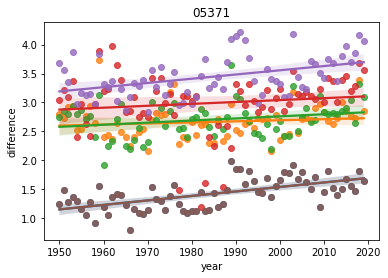

In [290]:
def night_rh(df_moisture_complete):
    for station in ["05371","01975","02014","05705","04104","05371"]:
        df_moisture_station = df_moisture_complete[df_moisture_complete["STATIONS_ID"]==station]
        day_moisture = df_moisture_station[df_moisture_station["hour"].isin([6,9,12,15,18,21])].groupby("year").mean().reset_index()
        day_moisture = day_moisture.rename(columns = {"RF_STD":"day_average"})

        night_moisture = df_moisture_station[df_moisture_station["hour"].isin([0,3,6,9,12,15,18,21])].groupby("year").mean().reset_index()
        night_moisture = night_moisture.rename(columns = {"RF_STD":"night_average"})
        moisture_concat = night_moisture.merge(day_moisture, on='year', how='left')

        moisture_concat = moisture_concat[["year","day_average","night_average"]]
        moisture_concat["difference"] = moisture_concat.apply(lambda x: x["night_average"] - x ["day_average"], axis = 1)
        #print(moisture_concat.head())
        sns.regplot(y = moisture_concat["difference"], x = moisture_concat.year)
        plt.title(f"{station}")
        plt.savefig(f"results/night_rh/comparaison/{station}.png")
        #plt.show()
        #sns.scatterplot(y = night_moisture["RF_STD"], x = night_moisture.year)

night_rh(df_moisture_complete)

02014 4.900471282164154e-05


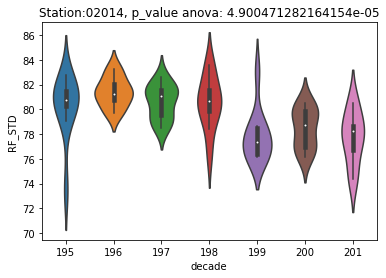

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   195    196   1.1648 0.8224  -1.451  3.7806  False
   195    197   0.3755 0.9994 -2.2403  2.9913  False
   195    198    0.315 0.9998 -2.3008  2.9308  False
   195    199  -2.3867 0.0962 -5.0024  0.2291  False
   195    200  -1.7627 0.3933 -4.3785  0.8531  False
   195    201  -2.5004 0.0701 -5.1161  0.1154  False
   196    197  -0.7893 0.9681 -3.4051  1.8265  False
   196    198  -0.8498 0.9545 -3.4655   1.766  False
   196    199  -3.5514  0.002 -6.1672 -0.9356   True
   196    200  -2.9275 0.0186 -5.5433 -0.3117   True
   196    201  -3.6651 0.0013 -6.2809 -1.0493   True
   197    198  -0.0605    1.0 -2.6762  2.5553  False
   197    199  -2.7621 0.0319 -5.3779 -0.1463   True
   197    200  -2.1382 0.1808  -4.754  0.4776  False
   197    201  -2.8758 0.0221 -5.4916   -0.26   True
   198    199  -2.7017 0.0385 -5.3175 -0.0859 

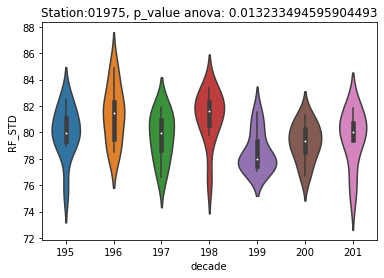

Multiple Comparison of Means - Tukey HSD, FWER=0.05 
group1 group2 meandiff p-adj   lower   upper  reject
----------------------------------------------------
   195    196    1.354 0.6692 -1.1893  3.8972  False
   195    197  -0.3439 0.9996 -2.8871  2.1993  False
   195    198   1.1539 0.8093 -1.3893  3.6971  False
   195    199  -1.4709 0.5784 -4.0141  1.0724  False
   195    200  -0.7639 0.9688 -3.3072  1.7793  False
   195    201  -0.4308 0.9985  -2.974  2.1124  False
   196    197  -1.6979 0.4047 -4.2411  0.8453  False
   196    198     -0.2    1.0 -2.7432  2.3432  False
   196    199  -2.8248 0.0201  -5.368 -0.2816   True
   196    200  -2.1179 0.1642 -4.6611  0.4253  False
   196    201  -1.7848 0.3443  -4.328  0.7585  False
   197    198   1.4979 0.5572 -1.0454  4.0411  False
   197    199  -1.1269 0.8257 -3.6701  1.4163  False
   197    200    -0.42 0.9987 -2.9632  2.1232  False
   197    201  -0.0869    1.0 -2.6301  2.4564  False
   198    199  -2.6248 0.0387  -5.168 -0.0816 

In [300]:
def study_climate_change_rh_revamped(df_moisture:pd.DataFrame):

    for i in range(195,202,1):
        this_df = df_moisture[df_moisture["year"].isin(range(i,i+10,1))]
        this_df = df_moisture[["year","RF_STD"]].groupby(["year"]).mean().reset_index()
        this_df = df_moisture[["year","RF_STD"]]
        this_df["decade"] = this_df.apply(lambda x: int(str(x["year"])[0:3]) , axis  = 1 )
  
    sns.scatterplot(y=this_df["RF_STD"], x=this_df["year"])
    sns.violinplot(x=this_df["decade"], y=this_df["RF_STD"])

    #for i in range(195,202,1):
    #to_stat = [this_df[this_df["decade"]==i]["RF_STD"] for i in range(195,202,1)]
    #fvalue, pvalue = stats.f_oneway(*to_stat)
    #this_df[this_df["decade"]==195]["TT_TU"], this_df[this_df["decade"]==201]["TT_TU"])
    #this_df[this_df["decade"]==196], this_df[this_df["decade"]==197], this_df[this_df["decade"]==198],this_df[this_df["decade"]==199],this_df[this_df["decade"]==200],this_df[this_df["decade"]==201])
    #rint(fvalue,pvalue)
df_moisture_this_id = df_moisture_complete[df_moisture_complete["STATIONS_ID"].isin(["05371","01975","02014","05705","04104","05371"])]
df_moisture_this_id = df_moisture_this_id[df_moisture_this_id["hour"].isin([0,3,6,9,12,15,18,21])]  
study_climate_change_rh_station(df_moisture=df_moisture_this_id)

### Old code, might include this or not

In [ ]:
"""
plot_optimal_temperature(df_airtemp, 
    temp_min=15,temp_max=25,
    hist_start=1950,hist_end=1985,
    start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, 
    moving_average=7)"""

'\nplot_optimal_temperature(df_airtemp, \n    temp_min=15,temp_max=25,\n    hist_start=1950,hist_end=1985,\n    start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, \n    moving_average=7)'

In [ ]:
### Now let's try to plot it only for the hours where we have the measurement value correct
"""plot_lw_RHt(df_moisture,
            thresholds=[87,90,93],
            start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, 
            hist_start=1950,hist_end=1985, 
            hours=[3,6,9,12,15,18,21],
            moving_average=7,
            )"""

'plot_lw_RHt(df_moisture,\n            thresholds=[87,90,93],\n            start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, \n            hist_start=1950,hist_end=1985, \n            hours=[3,6,9,12,15,18,21],\n            moving_average=7,\n            )'

### I conclude that I must really calibrate the model: the differences are huge between 87 and 93% RH so

## Negative forecast
https://journals.ametsoc.org/view/journals/apme/30/4/1520-0450_1991_030_0463_trhdff_2_0_co_2.xml

In [ ]:
"""df_dryness = df_moisture.copy()
plot_dryness(df_dryness,start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, treshhold = 70)"""

'df_dryness = df_moisture.copy()\nplot_dryness(df_dryness,start_dd_mm=wheat_sawing_date, end_dd_mm=wheat_harvest_date, treshhold = 70)'

# Leaf wetness model 2

"The difference between T and dew point temperature (Td) is the dew point depression (DPD) which has also been suggested as a LWD estimator by Huber and Gillespie (1992) and Gillespie et al. (1993), based on the same observations done by Monteith (1957) in relation to RH. Duration of wetness is estimated as the length of time that DPD remains between two specific limits. The wetness criteria for this study were DPD ≤ 1.8 °C for wetness onset and DPD ≥ 2.2 °C for wetness dry-off (Rao et al., 1998)."

In [ ]:
"""df_dew_point = download_dwd_data("dew_point","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)

#Replacing unknown values with np.nan so they will not be counted in the statistic
df_dew_point.replace(-999.0, np.nan, inplace=True)"""

'df_dew_point = download_dwd_data("dew_point","hourly",1950,2019,ids = common_ids,dwd_links=dwd_links, is_test=False)\n\n#Replacing unknown values with np.nan so they will not be counted in the statistic\ndf_dew_point.replace(-999.0, np.nan, inplace=True)'

In [ ]:
#Checking data integrity and quality
"""df_dpd = df_dew_point.copy()
measures = df_dpd.groupby("year").count()
sns.lineplot(x=measures.index,y=measures.TD)
plot_lw_dpd(df_dpd,start_dd_mm=wheat_sawing_date,end_dd_mm=wheat_harvest_date)"""

'df_dpd = df_dew_point.copy()\nmeasures = df_dpd.groupby("year").count()\nsns.lineplot(x=measures.index,y=measures.TD)\nplot_lw_dpd(df_dpd,start_dd_mm=wheat_sawing_date,end_dd_mm=wheat_harvest_date)'